<a href="https://colab.research.google.com/github/sdevi1234/plant-village-related-programs/blob/main/resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [12]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import cv2
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import keras
from keras.models import Sequential, Model,load_model
from tensorflow.keras.optimizers import SGD
from keras.callbacks import EarlyStopping,ModelCheckpoint
from google.colab.patches import cv2_imshow
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
tf.config.list_physical_devices('GPU') 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [5]:
train_path="/content/drive/MyDrive/Tomato Diseases and Pests-Improved YOLO-V3 CNN/pv-small-dataset/train"
test_path="/content/drive/MyDrive/Tomato Diseases and Pests-Improved YOLO-V3 CNN/pv-small-dataset/test"
class_names=os.listdir(train_path)
class_names_test=os.listdir(test_path)

In [6]:
print(class_names)
print(class_names_test)


['Apple___Apple_scab', 'Corn_(maize)___Common_rust_', 'Grape___Esca_(Black_Measles)']
['Corn_(maize)___Common_rust_', 'Apple___Apple_scab', 'Grape___Esca_(Black_Measles)']


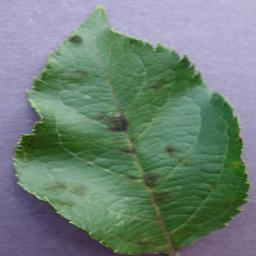

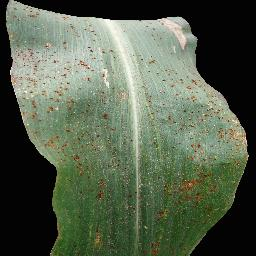

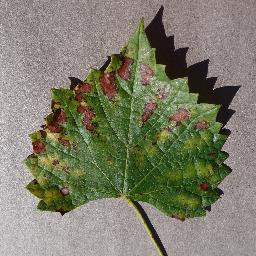

In [8]:
image_apple_leaf=cv2.imread("/content/drive/MyDrive/Tomato Diseases and Pests-Improved YOLO-V3 CNN/pv-small-dataset/test/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG")
cv2_imshow(image_apple_leaf)
image_corn_leaf=cv2.imread("/content/drive/MyDrive/Tomato Diseases and Pests-Improved YOLO-V3 CNN/pv-small-dataset/test/Corn_(maize)___Common_rust_/RS_Rust 1576.JPG")
cv2_imshow(image_corn_leaf)
image_Grape_leaf=cv2.imread("/content/drive/MyDrive/Tomato Diseases and Pests-Improved YOLO-V3 CNN/pv-small-dataset/test/Grape___Esca_(Black_Measles)/03f815cb-cdcd-4486-a142-f2ac59a4bf48___FAM_B.Msls 4315.JPG")
cv2_imshow(image_Grape_leaf)

In [9]:
train_datagen = ImageDataGenerator(zoom_range=0.15,width_shift_range=0.2,height_shift_range=0.2,shear_range=0.15)
test_datagen = ImageDataGenerator()

In [11]:
train_generator = train_datagen.flow_from_directory("/content/drive/MyDrive/Tomato Diseases and Pests-Improved YOLO-V3 CNN/pv-small-dataset/train",target_size=(224, 224),batch_size=32,shuffle=True,class_mode='binary')
test_generator = test_datagen.flow_from_directory("/content/drive/MyDrive/Tomato Diseases and Pests-Improved YOLO-V3 CNN/pv-small-dataset/test",target_size=(224,224),batch_size=32,shuffle=False,class_mode='binary')

Found 1633 images belonging to 3 classes.
Found 636 images belonging to 3 classes.


In [12]:
def identity_block(X, f, filters, stage, block):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    F1, F2, F3 = filters

    X_shortcut = X
   
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X = Add()([X, X_shortcut])# SKIP Connection
    X = Activation('relu')(X)

    return X

In [13]:
def convolutional_block(X, f, filters, stage, block, s=2):
   
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    F1, F2, F3 = filters

    X_shortcut = X

    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    X_shortcut = Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X

In [14]:
def ResNet50(input_shape=(224, 224, 3)):

    X_input = Input(input_shape)

    X = ZeroPadding2D((3, 3))(X_input)

    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')


    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    X = AveragePooling2D(pool_size=(2, 2), padding='same')(X)
    
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [15]:
base_model = ResNet50(input_shape=(224, 224, 3))

In [16]:
headModel = base_model.output
headModel = Flatten()(headModel)
headModel=Dense(256, activation='relu', name='fc1',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel=Dense(128, activation='relu', name='fc2',kernel_initializer=glorot_uniform(seed=0))(headModel)
headModel = Dense( 1,activation='sigmoid', name='fc3',kernel_initializer=glorot_uniform(seed=0))(headModel)

In [17]:
model = Model(inputs=base_model.input, outputs=headModel)

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 64  9472        ['zero_padding2d[0][0]']         
                                )                                                                 
                                                                                              

In [19]:
for layer in base_model.layers:
    layer.trainable = False

In [20]:
for layer in model.layers:
    print(layer, layer.trainable)

<keras.engine.input_layer.InputLayer object at 0x7f6fd009bdd0> False
<keras.layers.convolutional.ZeroPadding2D object at 0x7f6fd0089d90> False
<keras.layers.convolutional.Conv2D object at 0x7f6f5d316910> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6f5d2bb590> False
<keras.layers.core.activation.Activation object at 0x7f6f5d2967d0> False
<keras.layers.pooling.MaxPooling2D object at 0x7f6f5d2b1ed0> False
<keras.layers.convolutional.Conv2D object at 0x7f6f5d217890> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6f5d235f50> False
<keras.layers.core.activation.Activation object at 0x7f6f5d239350> False
<keras.layers.convolutional.Conv2D object at 0x7f6f5d23f290> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f6f5d23ff50> False
<keras.layers.core.activation.Activation object at 0x7f6f5d23dfd0> False
<keras.layers.convolutional.Conv2D object at 0x7f6f5d2495d0> False
<keras

In [21]:
es=EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)

In [31]:
mc = ModelCheckpoint('/content/gdrive/My Drive/best_model.h5', monitor='val_accuracy', mode='max')

In [32]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
H = model.fit_generator(train_generator,validation_data=test_generator,epochs=2,verbose=1,callbacks=[mc,es])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


Epoch 1/2
52/52 [==============================] - ETA: 0s - loss: 0.0000e+00 - accuracy: 0.4354

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


52/52 [==============================] - 459s 9s/step - loss: 0.0000e+00 - accuracy: 0.4354 - val_loss: 0.0000e+00 - val_accuracy: 0.2516
Epoch 2/2
52/52 [==============================] - 36s 686ms/step - loss: 0.0000e+00 - accuracy: 0.4299 - val_loss: 0.0000e+00 - val_accuracy: 0.2516


In [37]:
model.evaluate_generator(test_generator)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  """Entry point for launching an IPython kernel.


[0.0, 0.2515723407268524]

In [38]:
model_json = model.to_json()
with open("/content/gdrive/My Drive/model.json","w") as json_file:
  json_file.write(model_json)

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


In [39]:
from keras.models import model_from_json

In [41]:
def predict_(image_path):
    #Load the Model from Json File
    json_file = open('/content/gdrive/My Drive/model.json', 'r')
    model_json_c = json_file.read()
    json_file.close()
    model_c = model_from_json(model_json_c)
    #Load the weights
    model_c.load_weights("/content/gdrive/My Drive/best_model.h5")
    #Compile the model
    opt = SGD(lr=1e-4, momentum=0.9)
    model_c.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])
    #load the image you want to classify
    image = cv2.imread(image_path)
    image = cv2.resize(image, (224,224))
    cv2_imshow(image)
    #predict the image
    preds = model_c.predict(np.expand_dims(image, axis=0))[0]
    if preds==0:
        print("Predicted Label:Apple-leaf")
    elif preds==1: 
        print("Predicted Label:corn-leaf")
    else:
        print("Predicted Label:Grape-leaf")

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


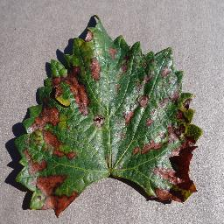

Predicted Label:Apple-leaf


In [42]:
predict_("/content/drive/MyDrive/Tomato Diseases and Pests-Improved YOLO-V3 CNN/pv-small-dataset/test/Grape___Esca_(Black_Measles)/011bb69d-fb9c-4fb9-b8cc-031e91270ec2___FAM_B.Msls 4288.JPG")